In [2]:
import random
import math
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn import preprocessing
from math import log

from torch_models import LSTMMemory

# OTHER SETUP

In [3]:
def curve_plot(rows, cols, X, y, prefix=""):
  axs = (plt.figure(constrained_layout=True)
      .subplots(rows, cols, sharex=True, sharey=True))
  
  if rows > 1:
    for i in range(rows):
      if cols > 1:
        for j in range(cols):
          axs[i][j].set(title = f"{prefix}Input {j}, output {i}")
          axs[i][j].plot(X[:, :, j].tolist()[0], label=f"input {j}")
          axs[i][j].plot(y[:, :, i].tolist()[0], label=f"output {i}")
      else:
        axs[i].set(title = f"{prefix}Input, output {i}")
        axs[i].plot(X[:, :, 0].tolist()[0], label=f"input")
        axs[i].plot(y[:, :, i].tolist()[0], label=f"output {i}")

  else:
    if cols > 1:
      for j in range(cols):
          axs[j].set(title = f"{prefix}Input {j}, output")
          axs[j].plot(X[:, :, j].tolist()[0], label=f"input {j}")
          axs[j].plot(y[:, :, 0].tolist()[0], label=f"output")
    else:
      axs.set(title = f"{prefix}Input, output")
      axs.plot(X.tolist()[0], label=f"input")
      axs.plot(y.tolist()[0], label=f"output")

  print("Blue inputs, orange outputs")
  plt.show()

In [4]:
def filter(arr, kernel_size=4):
  kernel = np.ones(kernel_size)
  kernel = kernel / np.sum(kernel)
  new_arr = np.convolve(arr, kernel, mode='full')[:len(arr)]
  new_arr[:kernel_size] = arr[:kernel_size]
  return new_arr


In [5]:
filter(np.array([6, 1, 1, 4, 1, 1]), 4)

array([6.  , 1.  , 1.  , 4.  , 1.75, 1.75])

# Artificial Data

In [6]:
def random_sine(samples=50, max_amp=1, min_amp=0, max_freq=5, min_freq=0.2, freq_chaos=0.3, amp_chaos=0.1):
  phase = random.uniform(0, math.pi * 2)
  amp = random.uniform(min_amp, max_amp)
  offset = random.uniform(1-amp, amp-1)
  freq = random.uniform(min_freq, max_freq)
  phase_incr = 2 * freq * math.pi / samples
  output = []

  for _ in range(samples):
    phase += phase_incr
    output.append(math.sin(phase) * amp + offset)
    if random.random() < amp_chaos:
      amp = random.uniform(min_amp, max_amp)
      offset = random.uniform(1-amp, amp-1)
    if random.random() < freq_chaos:
      freq = random.uniform(min_freq, max_freq)
      phase_incr = 2 * freq * math.pi / samples

  return output

In [7]:
def random_nums(samples=50):
  return [random.random() for _ in range(samples)]

In [8]:
def permute_signal(signal, size_reduction = 3, max_pad = 5):
  # remove some points
  new_signal = list(signal)

  for i in range(size_reduction):
    point = random.randint(0, len(new_signal) - 1)
    del new_signal[point]

  # add interpolations
  for i in range(size_reduction):
    point = random.randint(1, len(new_signal) - 1)
    interp = (new_signal[point - 1] + new_signal[point]) / 2
    new_signal.insert(point, interp)

  # add noise
  for i in range(len(new_signal)):
    new_signal[i] += random.uniform(-0.05, 0.05)

  # add some zero padding in the beginning
  pad_num = random.randint(0, max_pad)
  padding = [0 for _ in range(pad_num)]
  new_signal = padding + new_signal[:len(new_signal) - pad_num]

  return new_signal
    

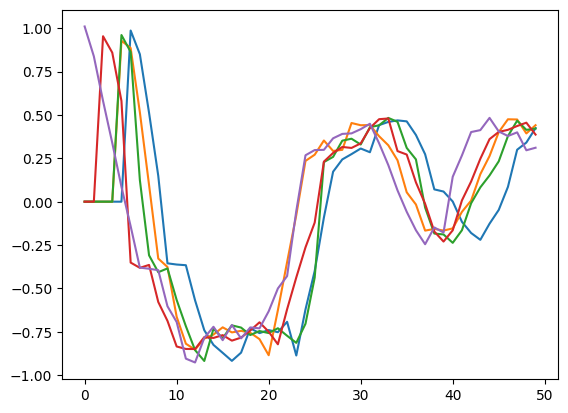

In [9]:
sequence = random_sine()
for _ in range(5):
  plt.plot(permute_signal(sequence))

In [10]:
def generate_data(sample_size=50, batch_size=6):
  X = torch.tensor([random_nums(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))
  
  y = torch.tensor([random_sine(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))

  return X, y


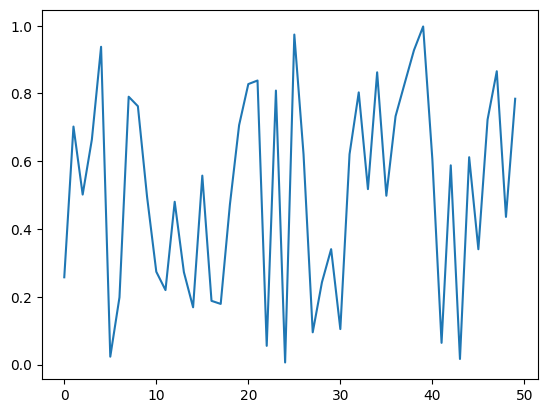

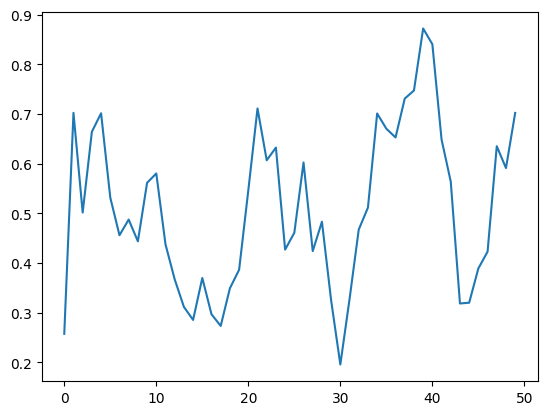

In [11]:
nums = random_nums()
plt.figure()
plt.plot(nums)

plt.figure()
filtered_nums = filter(np.array(nums))
plt.plot(filtered_nums)

# Real data

In [12]:
#from google.colab import drive
#drive.mount('/content/drive')

In [13]:
with open('./datasets/guitar-data-9-28.txt') as f:
  txt = f.readlines()
#model = LSTMMemory(15)
data_pts = []

for pt in txt:
  data_pts.append([float(feature) for feature in pt[:-2].split(' ') if feature != ''])

df = pd.DataFrame(data_pts)
df.columns = ['pitch', 'max', 'specFlat', 'specBright', 'time']

In [14]:
df.describe()

,pitch,max,specFlat,specBright,time
count,335.000000,335.000000,335.000000,335.000000,335.000000
mean,61.114231,0.282633,0.171766,0.348683,383.731418
std,8.267241,0.185517,0.090655,0.166177,365.242650
min,39.566500,0.034271,0.007414,0.015827,113.197000
25%,56.227750,0.152269,0.091557,0.213895,174.150000
50%,61.758600,0.244555,0.169524,0.330733,304.762000
75%,68.801800,0.354469,0.241361,0.462558,465.850500
max,80.649600,1.005350,0.421101,0.756427,2470.020000


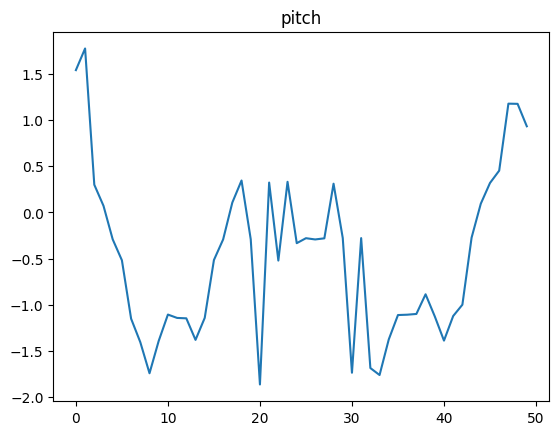

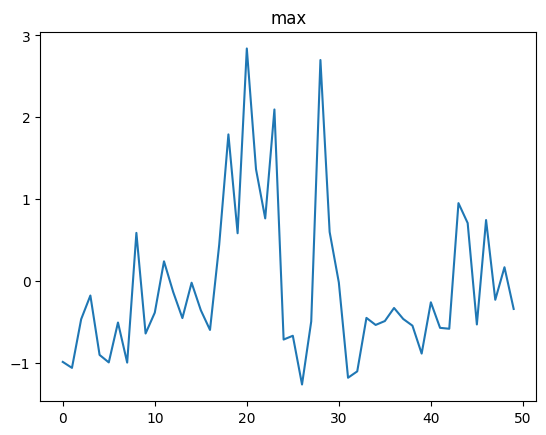

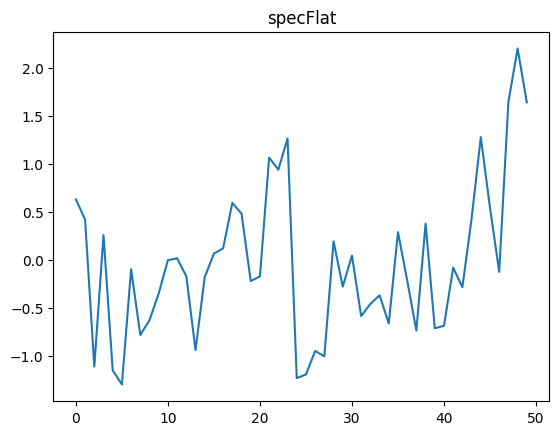

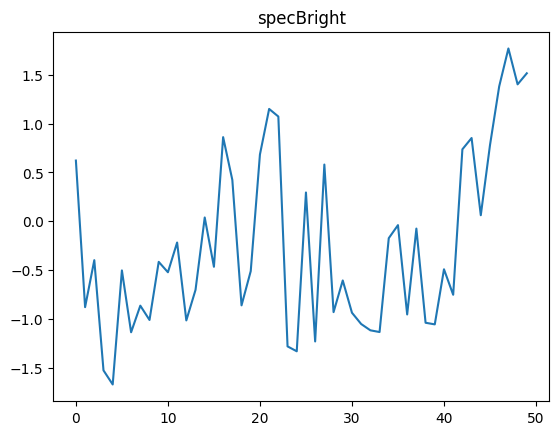

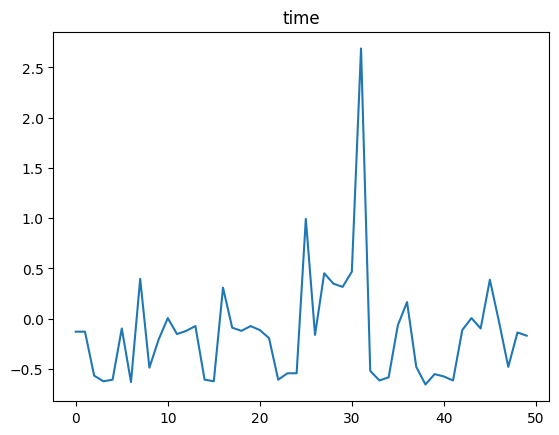

In [15]:
for col in df.columns:
  plt.figure()
  plt.title(col)
  plt.plot(StandardScaler().fit_transform(df[col].to_numpy().reshape(-1, 1))[:50])
  plt.show()

## Filtered Data

In [16]:
filtered_df = df.copy()
for col in filtered_df.columns:
  filtered_df[col] = filter(filtered_df[col].to_numpy(), 4)

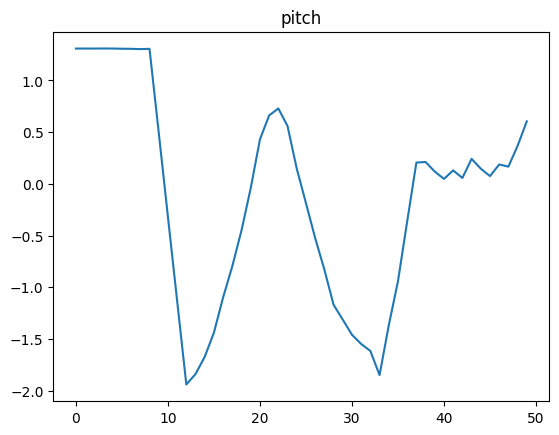

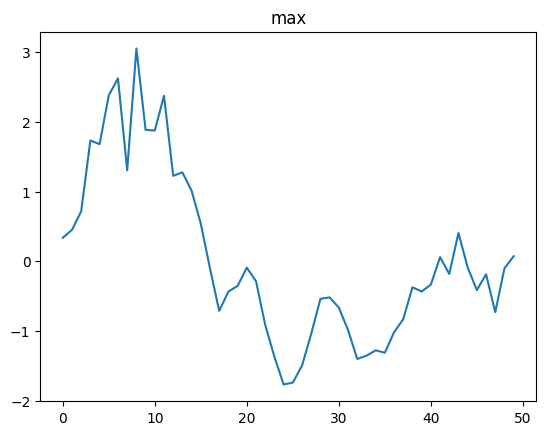

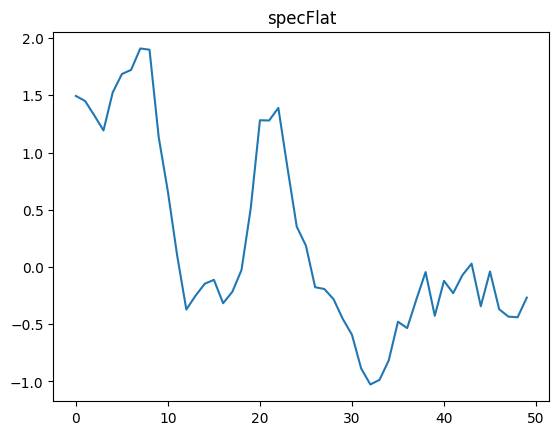

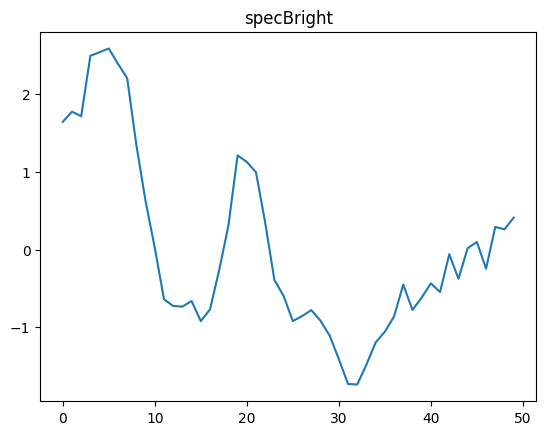

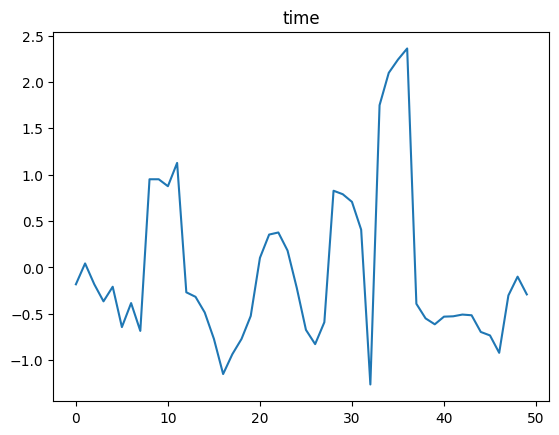

In [17]:
for col in df.columns:
  plt.figure()
  plt.title(col)
  plt.plot(StandardScaler().fit_transform(filtered_df[col].to_numpy().reshape(-1, 1))[200:250])
  plt.show()

# TESTING

## Random sine -> permuted random sine

In [18]:
def generate_randnums_permutedsines(sample_size=50, batch_size=6):
  X = torch.tensor([random_nums(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))
  
  y = torch.tensor([random_sine(sample_size) for _ in range(batch_size)]).reshape((batch_size, sample_size, 1))

  return X, y

Blue inputs, orange outputs


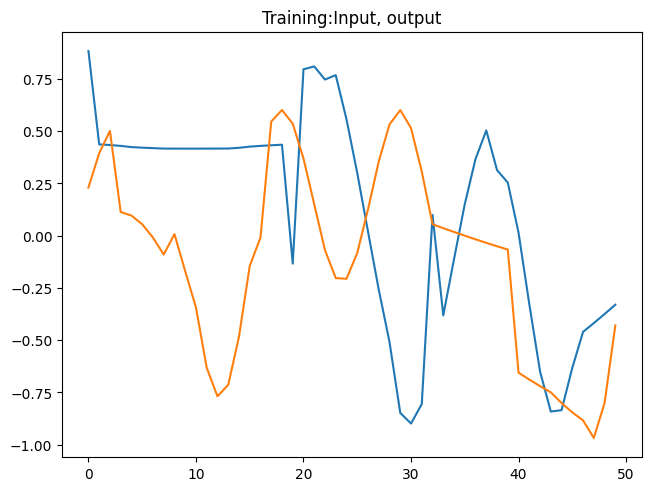

Blue inputs, orange outputs


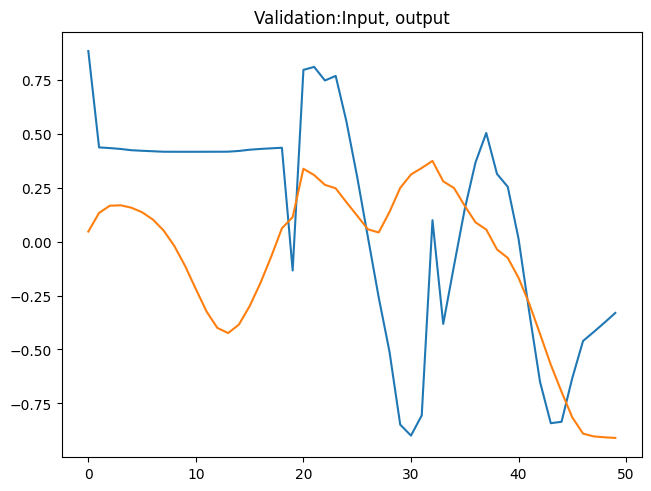

Blue inputs, orange outputs


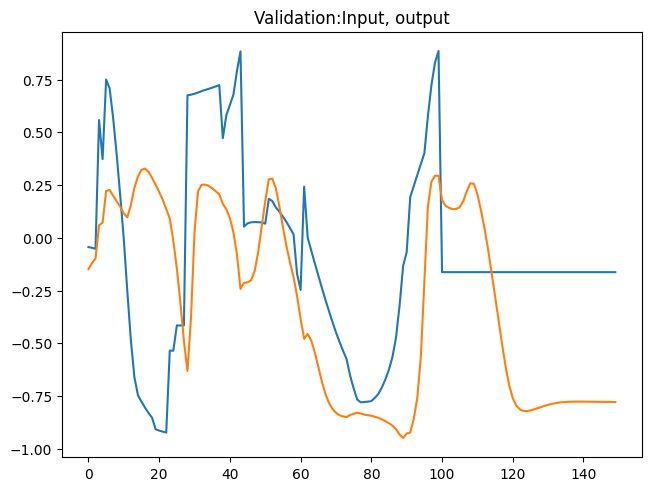

Blue inputs, orange outputs


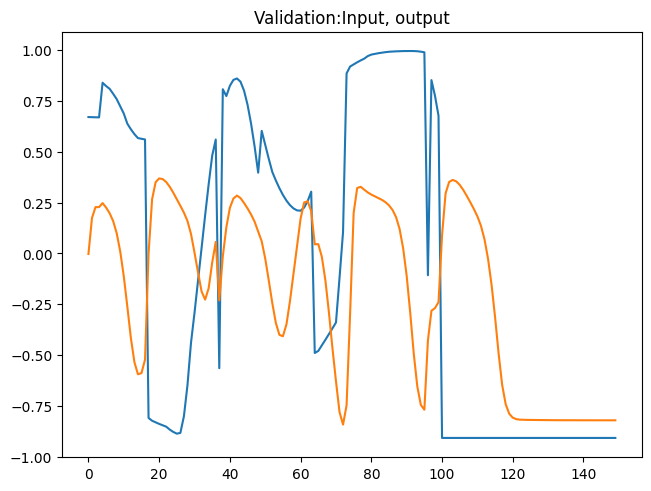

Blue inputs, orange outputs


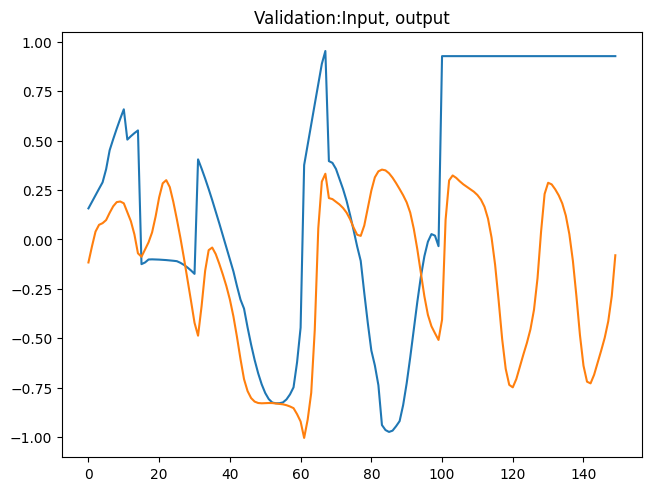

Blue inputs, orange outputs


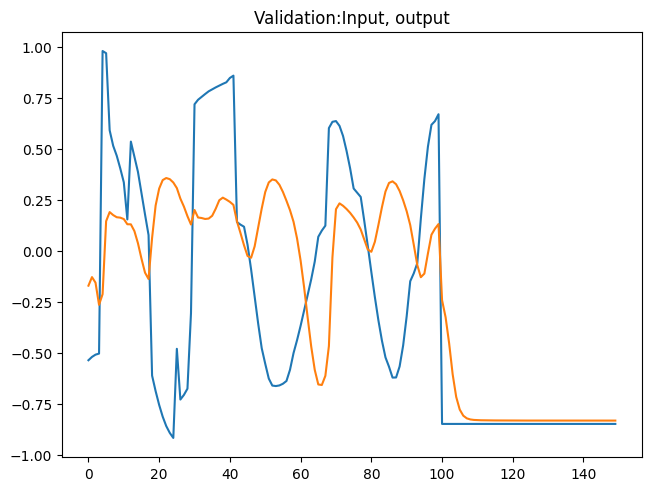

Blue inputs, orange outputs


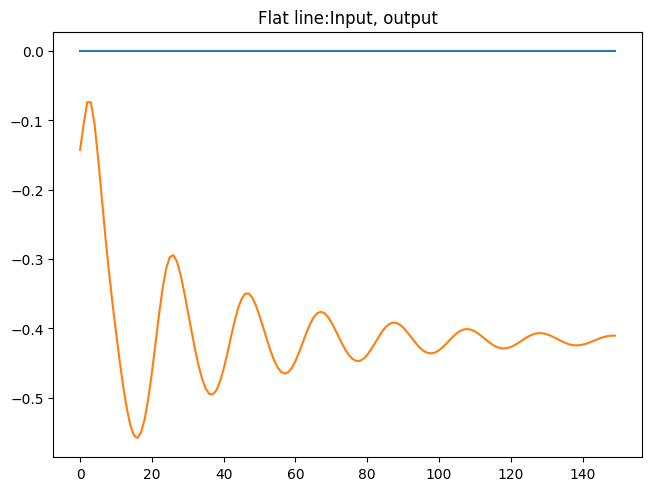

In [19]:
random.seed(45)
torch.manual_seed(42)

model = LSTMMemory(15)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=.02)
model.train()
x_list = random_sine(50)
X = torch.tensor([x_list for _ in range(6)]).reshape((6, 50, 1))
y_list = [point * 1 for point in random_sine(50)]
curve_plot(1, 1, X, torch.tensor(y_list).reshape(1, 50, 1), "Training:")

for j in range(500):
  optimizer.zero_grad()
  pred = model(X)
  y = torch.tensor([permute_signal(y_list) for _ in range(6)]).reshape((6, 50, 1))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  
  # print(f"Loss = {loss} but why do I care?")
model.eval()
with torch.no_grad():
  val_y = model(X)
curve_plot(1, 1, X, val_y, "Validation:")

for i in range(4):
  with torch.no_grad():
    finisher = random.uniform(-1, 1)
    test_X = torch.tensor((random_sine(100) + [finisher for _ in range(50)])).reshape((1, 150, 1))
    test_predicted_y = model(test_X)
  curve_plot(1, 1, test_X, test_predicted_y, "Validation:")

with torch.no_grad():
  test_X = torch.tensor([0 for _ in range(150)]).reshape((1, 150, 1)).float()
  test_predicted_y = model(test_X)
curve_plot(1, 1, test_X, test_predicted_y, "Flat line:")



# N random sines -> M random permuted sines

Blue inputs, orange outputs


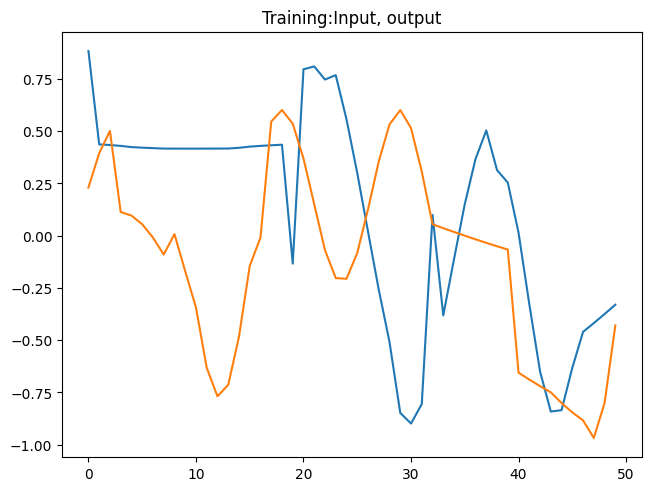

Blue inputs, orange outputs


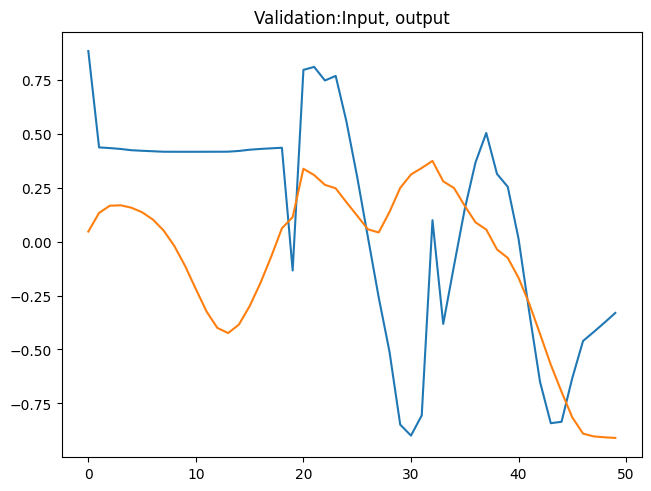

Blue inputs, orange outputs


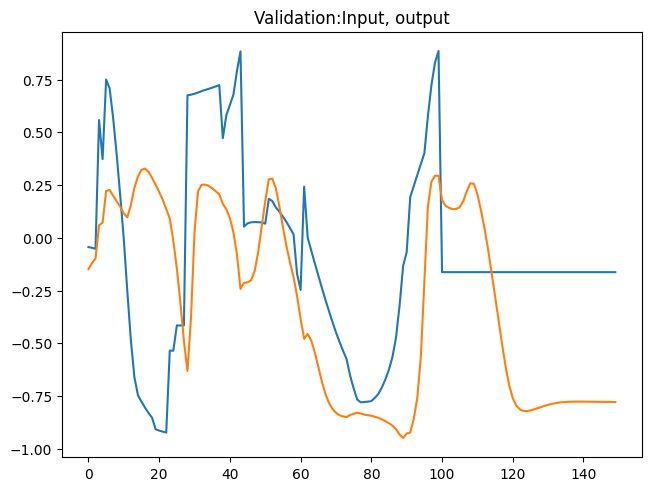

Blue inputs, orange outputs


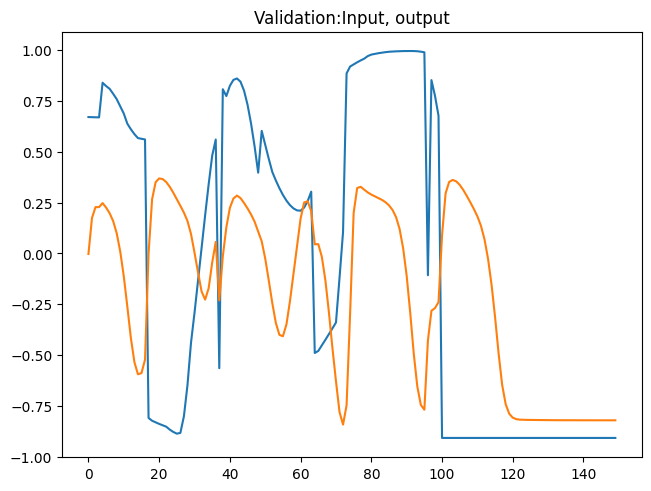

Blue inputs, orange outputs


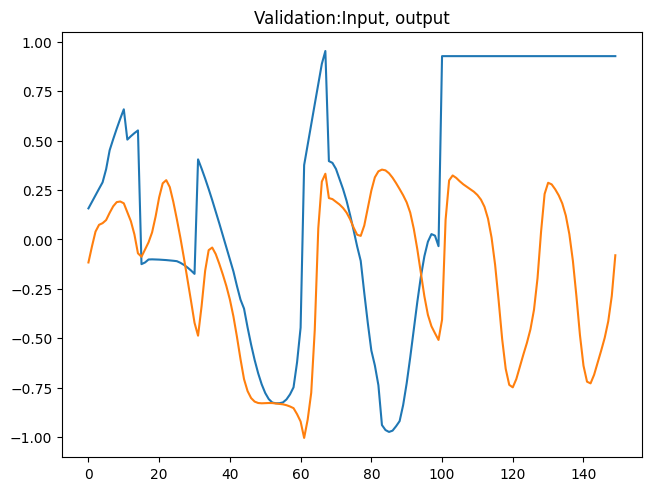

Blue inputs, orange outputs


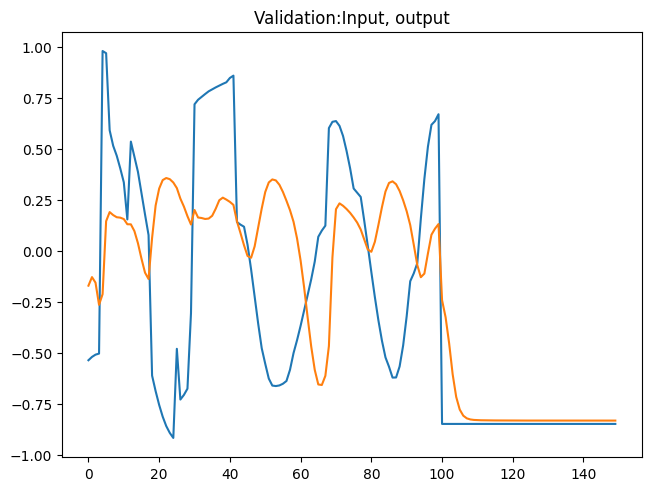

Blue inputs, orange outputs


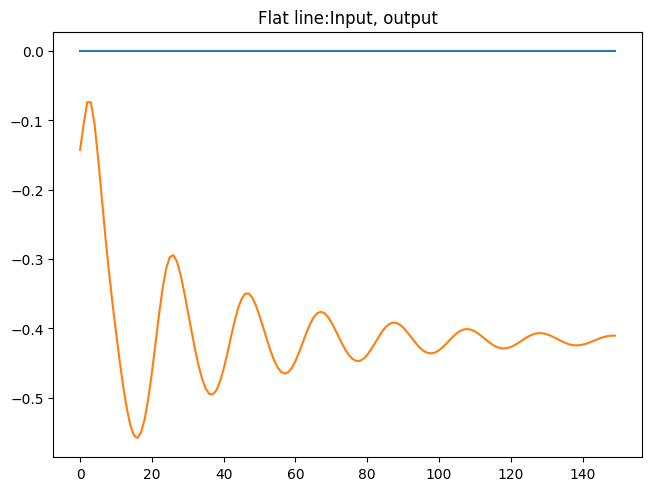

In [20]:
inputs = 2
outputs = 1

random.seed(20)
torch.manual_seed(41)

model_2d_2d = LSTMMemory(15, inputs, outputs)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model_2d_2d.parameters(), lr=.02)
model_2d_2d.train()
X_list = list(zip(*[random_sine(50) for _ in range(inputs)]))
X = torch.tensor([X_list for _ in range(6)]).float()
y_list_pure = [random_sine(50) for _ in range(outputs)]
true_y = list(zip(*y_list_pure))
curve_plot(outputs, inputs, X, torch.tensor(true_y).reshape((1, 50, outputs)), "TRAINING:")

for j in range(500):
  optimizer.zero_grad()
  pred = model_2d_2d(X)
  
  y_list = list(zip(*[permute_signal(y) for y in y_list_pure]))
  y = torch.tensor([y_list for _ in range(6)]).reshape((6, 50, outputs))
  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  
  # print(f"Loss = {loss}")
model_2d_2d.eval()


val_pred_y = model_2d_2d(X)
curve_plot(outputs, inputs, X, torch.tensor(val_pred_y).reshape((6, 50, outputs)), "VALIDATION:")



for i in range(4):
  with torch.no_grad():
    test_X_list = list(zip(*[random_sine(70) for _ in range(inputs)]))
    test_X = torch.tensor(test_X_list).reshape((1, 70, inputs))
    test_predicted_y = model_2d_2d(test_X)
  curve_plot(outputs, inputs, test_X, test_predicted_y, "TESTING:")
print("Predicted: ", test_predicted_y.tolist())

# Time since last note + velocity from Bonk

In [21]:
with open('dataset.txt') as f:
  txt = f.readlines()
model = LSTMMemory(15)
data_pts = []
times = []
vels = []

for pt in txt:
  time, vel = pt.split(' ')
  time = log(float(time))
  vel = float(vel[:-2])
  data_pts.append([time, vel])
  times.append(time)
  vels.append(vel)

times = times[::-1]
scaled_vels = preprocessing.scale(vels[::-1])
scaled_vels2 = model.fit_transform(np.array(vels).reshape(len(vels), 1))
data_pts_np = np.array(data_pts[::-1])

print("TIMES")
plt.figure()
plt.plot(times[:50])
plt.show()
print("VELS")
plt.figure()
plt.plot(scaled_vels[:50])
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'dataset.txt'

In [ ]:
X.shape

torch.Size([6, 50, 2])

# Training with multiple real datapoints to one output

favorites - pitch, max.  rand seed 40, torch seed 44

Blue inputs, orange outputs


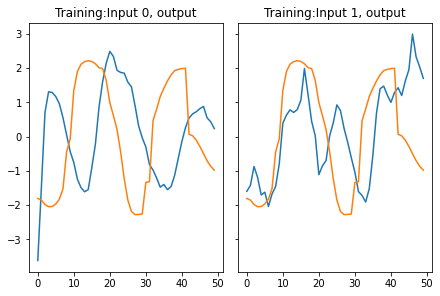

Loss = 0.2998849153518677
Loss = 0.10733169317245483
Loss = 0.10573959350585938
Loss = 0.07914425432682037
Loss = 0.09119866788387299
Loss = 0.1324319988489151
Loss = 0.11736475676298141
Loss = 0.04808926209807396
Loss = 0.06393053382635117
Loss = 0.08313484489917755
Blue inputs, orange outputs


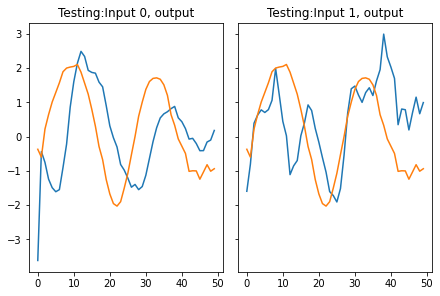

Blue inputs, orange outputs


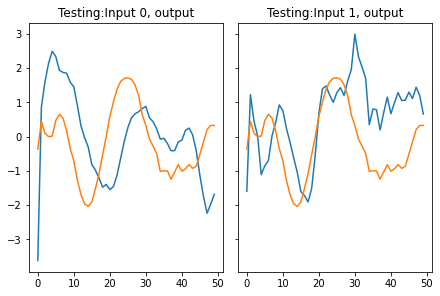

Blue inputs, orange outputs


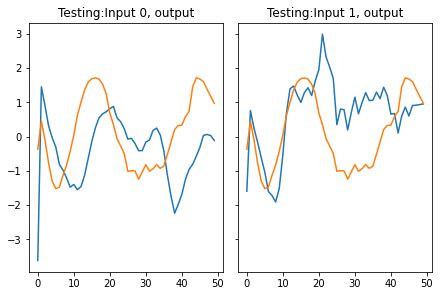

Blue inputs, orange outputs


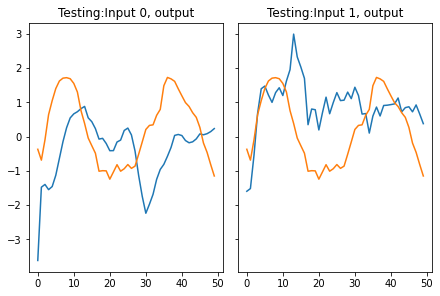

Blue inputs, orange outputs


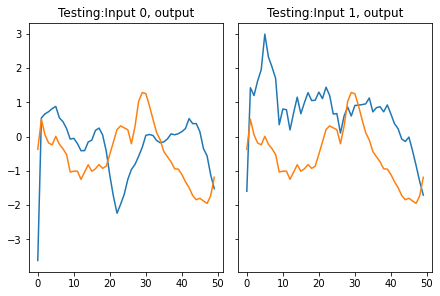

In [ ]:
random.seed(38)
torch.manual_seed(44)

data = filtered_df[['pitch', 'max']].to_numpy(copy=True)

model_2d = LSTMMemory(15, 2, 1)
scaled_data = torch.tensor(model_2d.fit_transform(preprocessing.scale(data)))
X_row = scaled_data[:50]
X = X_row.repeat(6, 1, 1)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model_2d.parameters(), lr=.02)
model_2d.train()

y_list = random_sine(50)
y_tensor = torch.tensor(y_list)
curve_plot(1, 2, X, y_tensor.reshape((1, 50, 1)) * 3, f"Training:")
for j in range(500):
  optimizer.zero_grad()
  pred = model_2d(X.float())
  y = torch.tensor([permute_signal(y_list) for _ in range(6)]).reshape((6, 50, 1))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  if j % 50 == 0:
    print(f"Loss = {loss}")
model_2d.eval()



for i in range(5):
  with torch.no_grad():
    start_index = int((i + 1)* 50 / 6 )
    test_X = scaled_data[start_index:start_index +  50].reshape(1, 50, 2).float()
    test_X[:, 0, :] = X_row[0]
    test_predicted_y = model_2d(test_X)

  curve_plot(1, 2, test_X, test_predicted_y * 3, "Testing:")

In [ ]:
scaled_data.shape

torch.Size([179, 2])

# Multiple real to multiple out

In [22]:
""" random.seed(1)
torch.manual_seed(42)

outputs = 3

model_2d = LSTMMemory(15, 2, outputs)
scaled_data = torch.tensor(model_2d.fit_transform(data_pts_np))
X_row = scaled_data[:50]
X = X_row.repeat(6, 1, 1)

y_lists = [random_sine(50, max_freq=5 + i * 3, ) for i in range(outputs)]

criterion = torch.nn.MSELoss()
optimizer = torch.optim.RMSprop(model_2d.parameters(), lr=.02)
model_2d.train()

for j in range(500):
  optimizer.zero_grad()
  pred = model_2d(X.float())

  y_lists_permuted = list(zip(*[permute_signal(y) for y in y_lists]))
  y = torch.tensor([y_lists_permuted for _ in range(6)]).reshape((6, 50, outputs))

  loss = criterion(pred, y)
  loss.backward()
  optimizer.step()

  if j % 50 == 49:
    print(f"Loss = {loss}")
model.eval()

y_tensor = torch.tensor(list(zip(*y_lists))).reshape(1, 50, outputs)
curve_plot(outputs, 2, X, y_tensor * 2, prefix="TRAINING:")

curve_plot(outputs, 2, X, model_2d(X.float()) * 2, prefix="VALIDATION:")

for i in range(4):
  with torch.no_grad():
    test_X = scaled_data[(i + 1) * 50:(i + 2) * 50].reshape(1, 50, 2).float()
    test_predicted_y = model_2d(test_X)
  curve_plot(outputs, 2, test_X, test_predicted_y * 2, prefix=f"TESTING ROUND {i}:") """

' random.seed(1)\ntorch.manual_seed(42)\n\noutputs = 3\n\nmodel_2d = LSTMMemory(15, 2, outputs)\nscaled_data = torch.tensor(model_2d.fit_transform(data_pts_np))\nX_row = scaled_data[:50]\nX = X_row.repeat(6, 1, 1)\n\ny_lists = [random_sine(50, max_freq=5 + i * 3, ) for i in range(outputs)]\n\ncriterion = torch.nn.MSELoss()\noptimizer = torch.optim.RMSprop(model_2d.parameters(), lr=.02)\nmodel_2d.train()\n\nfor j in range(500):\n  optimizer.zero_grad()\n  pred = model_2d(X.float())\n\n  y_lists_permuted = list(zip(*[permute_signal(y) for y in y_lists]))\n  y = torch.tensor([y_lists_permuted for _ in range(6)]).reshape((6, 50, outputs))\n\n  loss = criterion(pred, y)\n  loss.backward()\n  optimizer.step()\n\n  if j % 50 == 49:\n    print(f"Loss = {loss}")\nmodel.eval()\n\ny_tensor = torch.tensor(list(zip(*y_lists))).reshape(1, 50, outputs)\ncurve_plot(outputs, 2, X, y_tensor * 2, prefix="TRAINING:")\n\ncurve_plot(outputs, 2, X, model_2d(X.float()) * 2, prefix="VALIDATION:")\n\nfor i in r

In [ ]:
t1 = torch.Tensor([1, 2, 3])
t2 = torch.Tensor([4, 5, 6])
torch.stack([t1, t2], dim = -1)

tensor([[1., 4.],
        [2., 5.],
        [3., 6.]])

# Multiple real to multiple models

Loss for model 0 = 0.30767205357551575
Loss for model 1 = 0.6668943166732788
Loss for model 2 = 0.3767830431461334
Loss for model 0 = 0.06761482357978821
Loss for model 1 = 0.08487941324710846
Loss for model 2 = 0.09053072333335876
Loss for model 0 = 0.07908905297517776
Loss for model 1 = 0.0584508515894413
Loss for model 2 = 0.11278461664915085
Loss for model 0 = 0.08879556506872177
Loss for model 1 = 0.0528608039021492
Loss for model 2 = 0.06895122677087784
Loss for model 0 = 0.06014266982674599
Loss for model 1 = 0.044203415513038635
Loss for model 2 = 0.10918498039245605
Loss for model 0 = 0.04020703583955765
Loss for model 1 = 0.041867177933454514
Loss for model 2 = 0.14439405500888824
Loss for model 0 = 0.0686851218342781
Loss for model 1 = 0.04751686751842499
Loss for model 2 = 0.11468315124511719
Loss for model 0 = 0.04637469723820686
Loss for model 1 = 0.05191294848918915
Loss for model 2 = 0.13893502950668335
Loss for model 0 = 0.0740187019109726
Loss for model 1 = 0.05205091

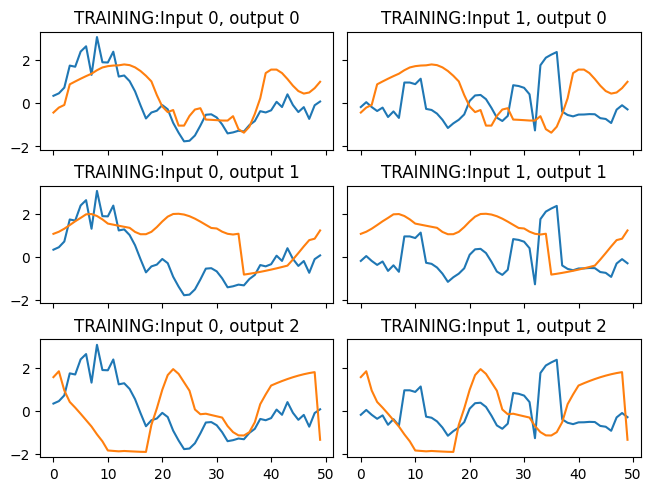

Blue inputs, orange outputs


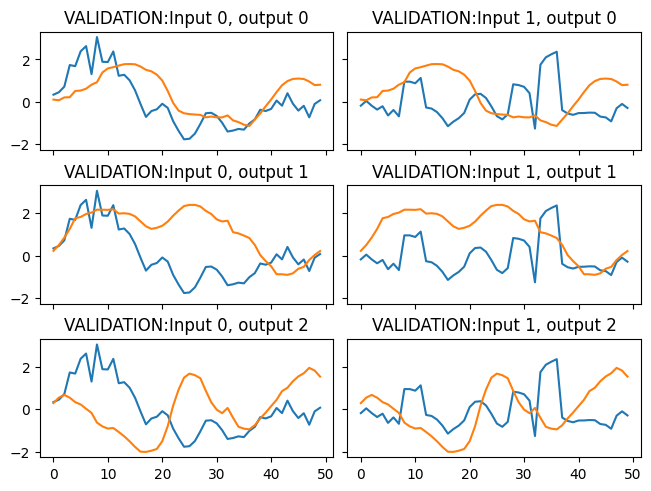

Blue inputs, orange outputs


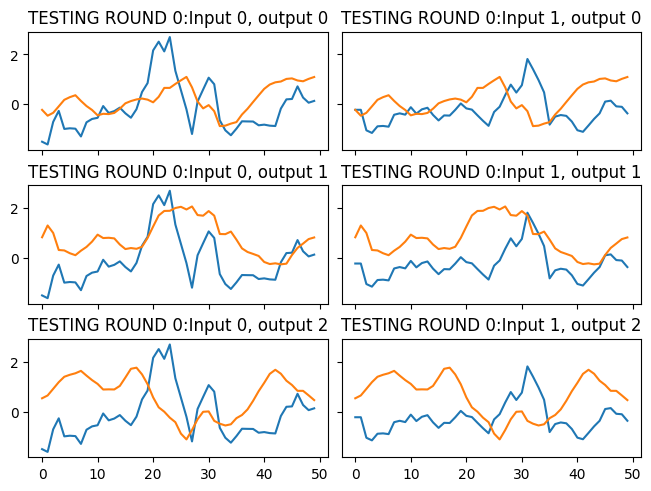

Blue inputs, orange outputs


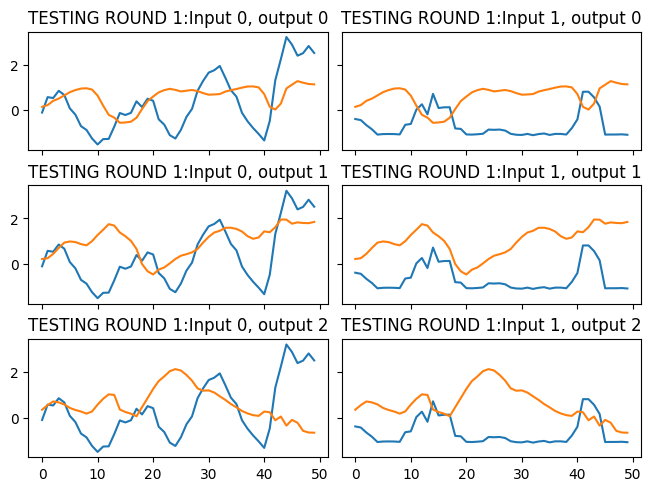

Blue inputs, orange outputs


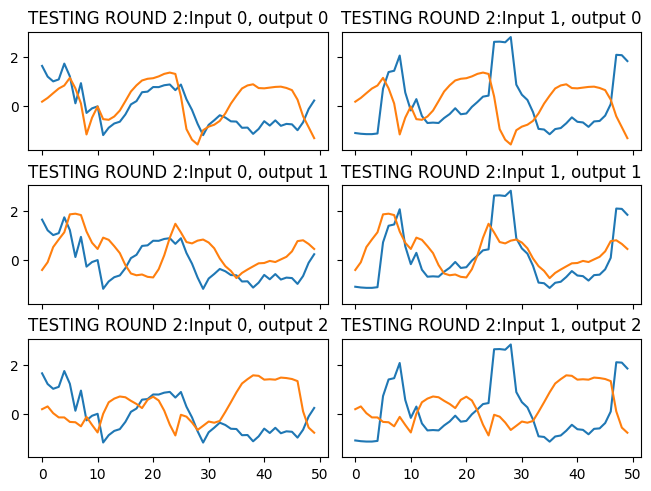

Blue inputs, orange outputs


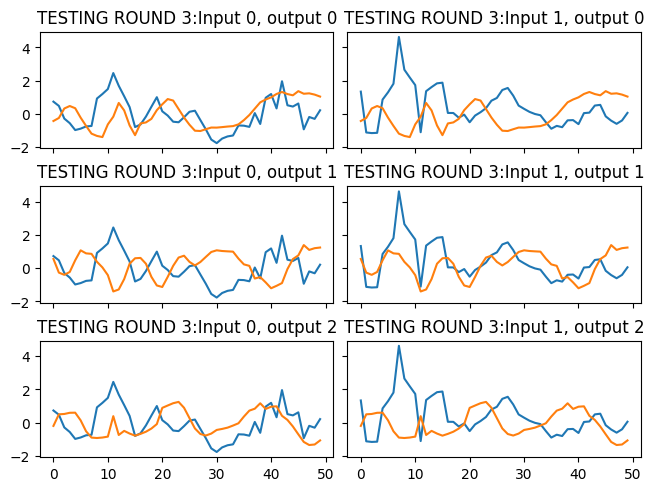

Blue inputs, orange outputs


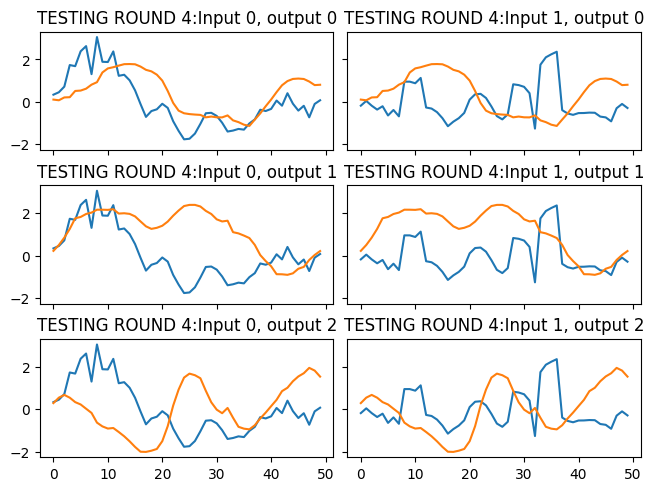

In [23]:
random.seed(93)
torch.manual_seed(48)

outputs = 3

models = [LSTMMemory(25, 2, 1) for _ in range(outputs)]
data_pts_np = filtered_df[['max', 'time']].to_numpy(copy=True)
for model in models:
  model.fit(data_pts_np)
scaled_data = torch.tensor(models[0].transform(data_pts_np))
X_row = scaled_data[200:250]
X = X_row.repeat(6, 1, 1)

y_lists = [random_sine(50) for _ in range(outputs)]

criterion = torch.nn.MSELoss()
optimizers = [torch.optim.RMSprop(model.parameters(), lr=.02) for model in models]
for model in models:
    model.train()

for j in range(500):
  for i in range(outputs):
    optimizers[i].zero_grad()
    pred = models[i](X.float() / 2)

    y = torch.tensor([permute_signal(y_lists[i]) for _ in range(6)]).reshape(6, 50, 1)

    loss = criterion(pred, y)
    loss.backward()
    optimizers[i].step()

    if j % 50 == 0:
      print(f"Loss for model {i} = {loss}")

for model in models:
    model.eval()

y_tensor = torch.tensor(list(zip(*y_lists))).reshape(1, 50, outputs)
curve_plot(outputs, 2, X, y_tensor * 2, prefix="TRAINING:")

valid_list = [model(X.float())[0] for model in models]
validation_out = torch.stack(valid_list, dim=-1).reshape(1, 50, outputs)
curve_plot(outputs, 2, X, validation_out * 2, prefix="VALIDATION:")

for i in range(5):
  with torch.no_grad():
    start_index = i * 50
    test_X = scaled_data[start_index:start_index +  50].reshape(1, 50, 2).float()
    test_predicted_y = torch.stack([model(test_X) for model in models], dim=-1).reshape(1, 50, outputs)
  curve_plot(outputs, 2, test_X, test_predicted_y * 2, prefix=f"TESTING ROUND {i}:")

In [ ]:
torch.stack(valid_list, dim=-1).shape

torch.Size([6, 50, 1, 2])

### Saving

In [ ]:
torch.save(models[0], "models/max-time-1.pt")

# Testing for live usage

In [ ]:
filtered_df[['max', 'time']].to_numpy()[0]

array([9.95274e-02, 3.36689e+02])

In [30]:
data[0].reshape(1, 2)

array([[9.95274e-02, 3.36689e+02]])

In [38]:
points.shape

(50, 1, 2)

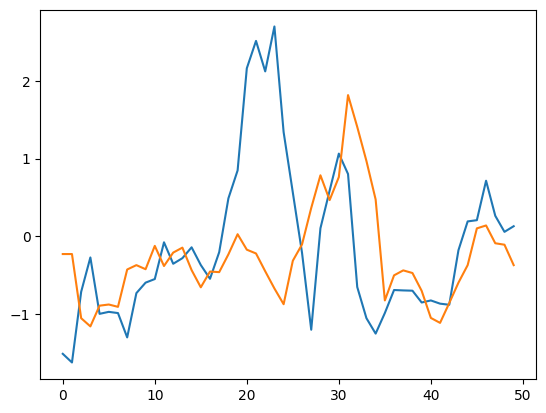

In [40]:
points = []
data = filtered_df[['max', 'time']].to_numpy()
scaler = StandardScaler()
scaler.fit(data)
for i in range(50):
    points.append(scaler.transform(data[i].reshape(1, 2)))
points = np.array(points).reshape(50, 2)
plt.plot(points)

In [56]:
live_out.item()

0.5460188388824463

In [51]:
live_outputs

[0.32074856758117676,
 0.007764056324958801,
 0.020819030702114105,
 0.13353250920772552,
 0.22423988580703735,
 0.24228474497795105,
 0.2628401517868042,
 0.1519714593887329,
 0.03673402965068817,
 -0.0545094832777977,
 -0.18624573945999146,
 -0.17360037565231323,
 -0.19262436032295227,
 -0.17439764738082886,
 -0.09040655940771103,
 0.01777520403265953,
 0.062006875872612,
 0.09330271929502487,
 0.10826923698186874,
 0.08291320502758026,
 0.028700359165668488,
 0.14407628774642944,
 0.3231621980667114,
 0.3248831033706665,
 0.40559861063957214,
 0.47931379079818726,
 0.548754096031189,
 0.33468717336654663,
 0.05176940932869911,
 -0.08652137964963913,
 -0.020246557891368866,
 -0.141789972782135,
 -0.4419933557510376,
 -0.43234580755233765,
 -0.3913537561893463,
 -0.3607116937637329,
 -0.2078208327293396,
 -0.09217476099729538,
 0.044036831706762314,
 0.1775628924369812,
 0.3077239990234375,
 0.3946097195148468,
 0.4392334520816803,
 0.4555204510688782,
 0.5075949430465698,
 0.51820826

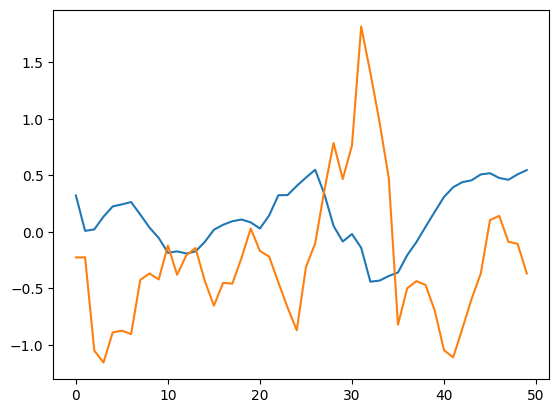

In [55]:
live_outputs = []
live_inputs1 = []
live_inputs2 = []
data = filtered_df[['max', 'time']].to_numpy()
test_model = models[0]
models[0].fit(data)
with torch.no_grad():
  model.reset_live()
  for i in range(50):
    live_out = test_model.forward_live(data[i].reshape(1, 2))
    live_input = test_model.transform(data[i].reshape(1, 2))
    live_outputs.append(live_out.item())
    live_inputs1.append(live_input[0, 0])
    live_inputs2.append(live_input[0, 1])
plt.plot(live_outputs)
plt.plot(live_inputs2)
plt.show()

In [ ]:
test_live_X[:, 1, :]

In [ ]:
torch.rand((1, 1, 1))